In [1]:
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

import cmbo
from IPython.display import display

from plot_cluster import *

%load_ext autoreload
%autoreload 2

/Users/rstiskalek/Projects/CMBOlympics/venv_cmbo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fname_cmb = "/Users/rstiskalek/Projects/CMBOlympics/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
cmb_tsz = cmbo.io.read_Planck_comptonSZ(fname_cmb)
cmb_tsz = cmbo.utils.smooth_map_gaussian(cmb_tsz, fwhm_arcmin=9.6, )


fname_clusters = "/Users/rstiskalek/Projects/CMBOlympics/data/observed_cluster_masses.toml"
obs_clusters = cmbo.io.load_observed_clusters(fname_clusters)

fname_rand_pointing = "/Users/rstiskalek/Projects/CMBOlympics/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00_RAND_POINTING.hdf5"
theta_rand, tsz_rand = cmbo.io.read_from_hdf5(fname_rand_pointing, "theta_rand", "tsz_rand")

In [3]:
fname = "../data/csiborg2_fof.hdf5"


optional_keys = ["Group_R_Crit200"]

positions, masses, optional_data = cmbo.io.load_halo_positions_masses(
    fname, "Coordinates", "Group_M_Crit200", optional_keys=optional_keys)

associations = cmbo.utils.identify_halo_associations(positions, masses, optional_data=optional_data)
pval, dist = cmbo.utils.compute_matching_matrix(obs_clusters, associations, 676.6)
matches = cmbo.utils.greedy_global_matching(pval, dist, obs_clusters, associations, 0.05)

100%|██████████| 358/358 [00:02<00:00, 170.38it/s]

Perseus (A426): min p-value = 9.167e-01
Cluster 17 (Shapley (A3562)) now orphaned (best remaining p=9.335e-02)
Cluster 18 (Perseus (A426)) now orphaned (best remaining p=9.167e-01)
Cluster 8 (Hercules (A2147)) now orphaned (best remaining p=1.303e-01)


In [4]:
k = 15

print(obs_clusters.names[k])

assoc, min_pval, d = matches[k]

print(f"p-value: {min_pval:.3e}, distance: {d:.2f} Mpc")

obs_pos = np.full((3,), 676.6 / 2)
r, ell, b = assoc.to_galactic_angular(obs_pos)
rc, ellc, bc = assoc.centroid_to_galactic_angular(obs_pos)
theta200 = np.rad2deg(np.atan(assoc.optional_data["Group_R_Crit200"] / r)) * 60


Shapley (A3571)
p-value: 7.748e-04, distance: 4.21 Mpc


In [5]:
cutout_gen = cmbo.corr.Pointing2DCutout(cmb_tsz, )

size_arcmin = 180

cut, ext = cutout_gen.get_cutout_2d(ell_deg=ellc, b_deg=bc, size_arcmin=size_arcmin)

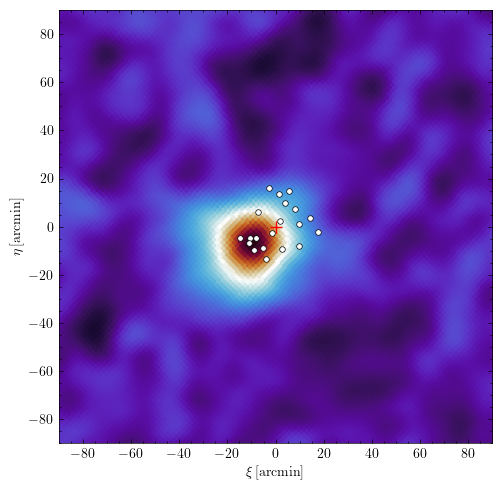

In [6]:
fig, ax = plot_cluster_cutout(cut, ext, ell, b, ellc, bc)

fig.savefig(f"cluster_{obs_clusters.names[k].replace(' ', '_')}.png", dpi=300)

display(fig)
plt.close("all")

In [7]:
profiler = cmbo.corr.PointingEnclosedProfile(cmb_tsz, )

In [8]:
cmbo.utils.compute_association_tsz_signals(associations, profiler, obs_pos, theta_rand, tsz_rand)

Computing association signals: 100%|██████████| 358/358 [01:54<00:00,  3.11it/s]


1.0

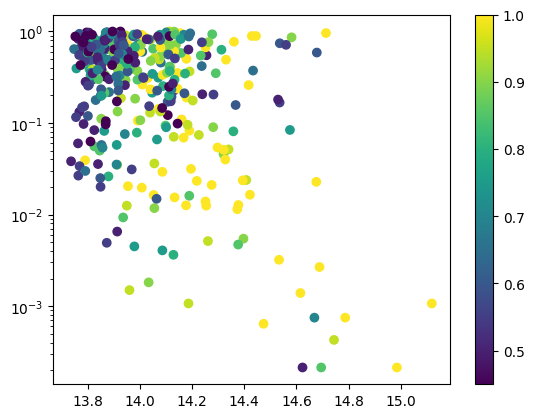

In [26]:
f = [assoc.fraction_present for assoc in associations]

plt.figure()
plt.scatter(
    [np.log10(np.median(assoc.masses)) for assoc in associations],
    [assoc.median_pval for assoc in associations],
    c=f
)

plt.colorbar()

plt.yscale("log")
plt.show()

[np.float64(15.118855511664778),
 np.float64(14.985148999283222),
 np.float64(14.786819962244424),
 np.float64(14.713308103967911),
 np.float64(14.676261906823633),
 np.float64(14.68850728330495),
 np.float64(14.47405067460275),
 np.float64(14.694946632950018),
 np.float64(14.615306067937468),
 np.float64(14.320604824820833),
 np.float64(14.416840308856786),
 np.float64(14.533412572821321),
 np.float64(14.445088560962878),
 np.float64(14.57521302758723),
 np.float64(14.254146167459767),
 np.float64(14.40771768640577),
 np.float64(14.277239277180106),
 np.float64(14.340136778934593),
 np.float64(14.366997081792098),
 np.float64(14.429097569471953),
 np.float64(14.098289491628664),
 np.float64(14.39440487869703),
 np.float64(14.275292644118869),
 np.float64(14.255278088782841),
 np.float64(14.37766966846255),
 np.float64(14.360490650275281),
 np.float64(14.421938848811184),
 np.float64(14.373413163247514),
 np.float64(14.290876021835857),
 np.float64(14.080371984727632),
 np.float64(14.1

In [185]:
signal = profiler.get_profiles_per_source(ell, b, theta200,)
pval = profiler.signal_to_pvalue(theta200, signal, theta_rand, tsz_rand)


Measuring profiles: 100%|██████████| 20/20 [00:00<00:00, 3992.10it/s]


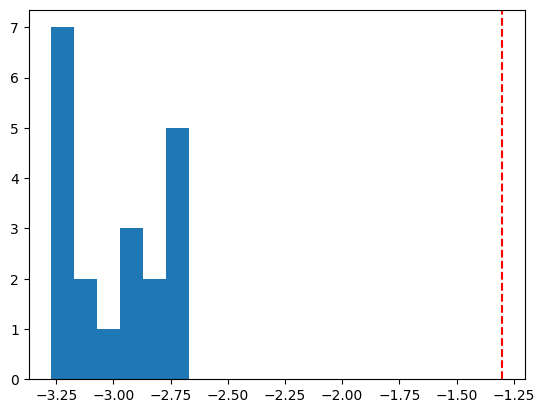

In [186]:
plt.figure()
plt.hist(np.log10(pval), bins="auto")
plt.axvline(np.log10(0.05), color="red", linestyle="--", label="Cluster p-value")

plt.show()